In [1]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Imports

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader


seed = 42

data_path = "/home/jovyan/work/satellite_data/tmp"
label_path = "data/label_masks"
year = 2018#range(2008,2019)
patch_size = [256,256,3]
overlap = 32
test_ratio = 0.2
val_ratio = 0.2


# 1.1 Data Collection

1.1 Data Collection
Label Areas:


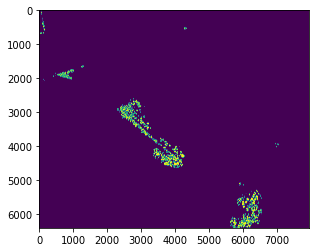

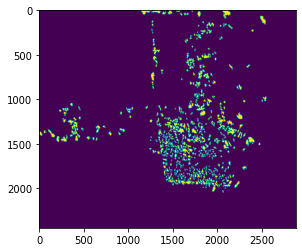

In [3]:

# get label area with export
src_label_nw = rasterio.open("data/label_masks/2018_labels_nw_09_03_2022.tif")
src_label_se = rasterio.open("data/label_masks/2018_labels_se_09_03_2022_v2.tif")
#TODO Dont forget to close them after !!!!
src_label_read_nw = src_label_nw.read()
src_label_read_se = src_label_se.read()
print("1.1 Data Collection")
print("Label Areas:")
show(src_label_read_nw)
show(src_label_read_se);

# 1.2 Patch Generation
Ensure that the pixel resolution for both files (labels and satellite image) is the same!!!

In [4]:
label_areas = [rasterio.open(os.path.join(label_path,i)) for i in os.listdir(label_path) if i.endswith(".tif")]
satellite_img = rasterio.open(os.path.join(data_path,str(year)+".vrt"))

## Create Label Area Patches

In [5]:
from rasterio.windows import from_bounds
# label_area may be referred to as mask
patches_labels = []
for la in label_areas:
    bounds =  la.bounds
    label_area_arr = la.read(1, window = from_bounds(*bounds, la.transform))

    patches = patchify(label_area_arr,(patch_size[0], patch_size[1]), 
                            step=patch_size[0]-overlap)
    reshaped_patches = np.reshape(patches, 
                                (patches.shape[0]*patches.shape[1], 
                                patches.shape[2], patches.shape[3])) 
                                # = (#patches, 256, 256)
    patches_labels.extend(reshaped_patches)

# patches: first cutout = (27, 34, 256, 256); second cutout = (10, 12, 256, 256) 
# => combined: 27 * 34 + 10 * 12
print("Mask/Label Patch Shape:", len(patches_labels))

Mask/Label Patch Shape: 1100


## Create Satellite Area Patches

In [6]:
patches_satellite = []
for la in label_areas:
    # get coordinates
    bounds = la.bounds    
    satellite_area_arr = satellite_img.read(None, window = from_bounds(*bounds, satellite_img.transform))

    patches = patchify(satellite_area_arr, 
                            (patch_size[2], patch_size[0], patch_size[1]), 
                            step=patch_size[0]-overlap)[0]
    reshaped_patches = np.reshape(patches, 
                                    (patches.shape[0]*patches.shape[1], 
                                    patches.shape[2], patches.shape[3], patches.shape[3]))
                                    # = (#patches, 3, 256, 256)
    patches_satellite.extend(reshaped_patches)
print("Satellite Patch Shape:", len(patches_satellite))

Satellite Patch Shape: 1100


# 1.3 Data Preparation for Training

Single Patch:


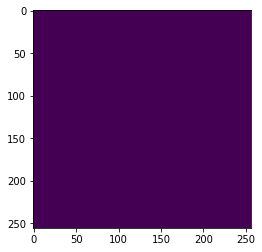

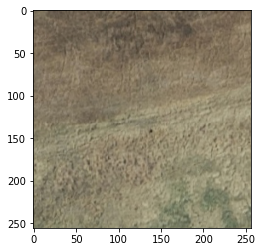

In [7]:
# visualize single patch
print("Single Patch:")
show(patches_labels[9])
show(patches_satellite[9]);

## 1.3.1 Reshape Patches to Fit to the Model

In [8]:
X = np.array(patches_satellite)/255
y = np.array(patches_labels)

## 1.3.2 Feature Scaling & Data Correction

#### Create Training and Test Dataset

In [9]:
from sklearn.model_selection import train_test_split
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=val_ratio, random_state=seed)

# 2. UNet 


In [10]:
from Unet.dataset import InMemorySatDataset

In [11]:
epochs = 10
batch_size = 16
lr = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:

train_dataset = InMemorySatDataset(X_train,y_train)
val_dataset = InMemorySatDataset(X_val,y_val)
test_dataset = InMemorySatDataset(X_test,y_test)

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [13]:
from Unet.models import UNet
from Unet.train_net import train
import time


In [14]:
net = UNet(3,2)
train_dl = DataLoader(train_dataset,batch_size=batch_size,num_workers=1)
val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=1)

In [15]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr)
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,device)

Epoch 0/9
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7350 Acc: 0.5239250063896179
valid Loss: 0.6234 Acc: 0.835161566734314
Epoch 1/9
----------
train Loss: 0.6187 Acc: 0.8186154365539551
valid Loss: 0.5634 Acc: 0.9060114622116089
Epoch 2/9
----------
train Loss: 0.5295 Acc: 0.925150990486145
valid Loss: 0.4976 Acc: 0.9457257986068726
Epoch 3/9
----------
train Loss: 0.4751 Acc: 0.9530085325241089
valid Loss: 0.4480 Acc: 0.966140866279602
Epoch 4/9
----------
train Loss: 0.4298 Acc: 0.9699422121047974
valid Loss: 0.4098 Acc: 0.9749305248260498
Epoch 5/9
----------
train Loss: 0.4001 Acc: 0.9742894768714905
valid Loss: 0.3800 Acc: 0.977626383304596
Epoch 6/9
----------
train Loss: 0.3741 Acc: 0.9787158370018005
valid Loss: 0.3600 Acc: 0.9815717339515686
Epoch 7/9
----------
train Loss: 0.3555 Acc: 0.9812328219413757
valid Loss: 0.3465 Acc: 0.9823880195617676
Epoch 8/9
----------
train Loss: 0.3413 Acc: 0.9823577404022217
valid Loss: 0.3345 Acc: 0.9830235838890076
Epoch 9/9
----------
train Loss: 0.3344 Acc: 0.982449889183044

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [10]:
from Unet.train_net import train_net
from Unet.models import UNet

In [11]:

amp = False
save_dir = "saved_models"


In [13]:

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=3, n_classes=2, bilinear=False)


net = net.to(device=device)

train_net(net=net,
          datasets=[train_dataset,val_dataset],
          save_dir = save_dir,
          epochs=epochs,
          batch_size=batch_size,
          save_checkpoint=False,
          learning_rate=lr,
          device=device,
          amp=amp)


Epoch 1/5:   0%|          | 0/704 [00:00<?, ?img/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 5/5: 100%|██████████| 704/704 [00:15<00:00, 45.86img/s, loss (batch)=1.25]


## 2.3 Validation

In [16]:
net = net
out = net(test_dataset[11]["x"].unsqueeze(0).to(device))

In [17]:
img = F.softmax(out,dim=1)
img = torch.argmax(img,dim=1)
img = img.cpu().numpy()


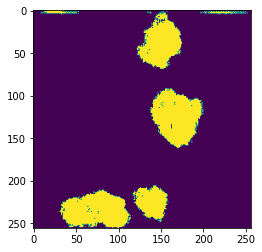

<AxesSubplot:>

In [18]:
show(img)

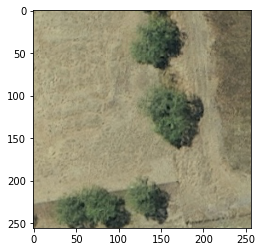

In [19]:
test_dataset.get_img(11)

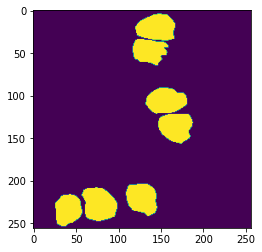

In [20]:
test_dataset.get_mask(11)